# Weather Image Recognition

In this notebook I am going to create a weather image recognition system. The goal is to take an image as input and to return the weather prediction. For training, I use the Weather Image Recognition dataset from Kaggle (link: https://www.kaggle.com/jehanbhathena/weather-dataset). <br> <br>
I plan to investigate the following topics: <br>
- Plot data distribution and investigate the dataset
- Create train-test split to already have hold out test set.
- Create input pipeline for CNN training using tensorflow's ImageDataGenerator class (with only some basic augmentations like 
   flipping in the beginning).
- Train different state-of-the-art CNN architectures on the trainining set and compare their performance on the validation set. Use threef old cross validation. Also: Create own CNN architecture (nice to also keep important things in mind about CNN architectures!). 
- Add data augmentations to improve performance (check which augmentations fit in different notebook)
- Try different image sizes to find the optimal one.
- Try different imbalance strategies.
- Use Bayesian Hyperparameter Search to optimize hyperparameters.
- Test final model on hold-out test set to check distribution on real world data.

In [55]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow_addons as tfa
import glob
import csv
import imgaug.augmenters as iaa
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [8,8]

In [2]:
# check if GPU is recognized
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# set global important variables
NUM_CLASSES = 11

# Load Data

In [4]:
path = 'dataset'
path_imgs = list( map(lambda x: x.replace("dataset"+os.path.sep, ""), list(glob.glob(path+'/**/*.jpg'))))
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='filepath').astype(str)
labels = pd.Series(labels, name='label')
df = pd.concat([file_path, labels], axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,filepath,label
0,hail\0378.jpg,hail
1,snow\1397.jpg,snow
2,hail\0480.jpg,hail
3,glaze\6445.jpg,glaze
4,snow\0861.jpg,snow


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6862 entries, 0 to 6861
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  6862 non-null   object
 1   label     6862 non-null   object
dtypes: object(2)
memory usage: 107.3+ KB


Okay perfect! In Kaggle its stated that there should be 6862 images in total, so we've read out all images. Now let's plot the data distribution to get a better understanding of the dataset.

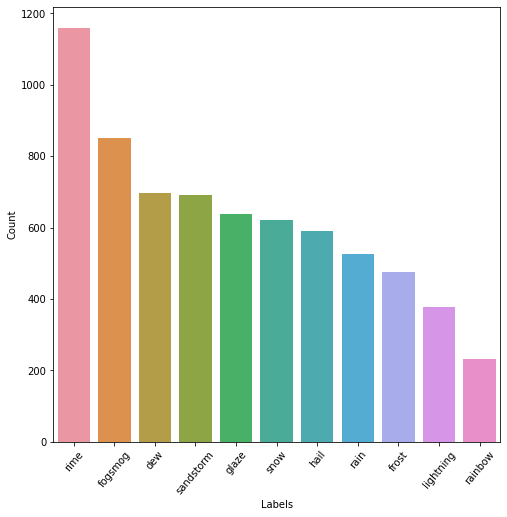

In [6]:
counts = df["label"].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

Okay. The dataset is definetly imbalanced! Let's later apply some imbalance strategies to check if model performance can be improved to the model trained on the imbalanced dataset. <br> <br>
<b> IMPORTANT: </b> Don't change the distribution on the validation set and the hold-out test set! They should reflect the real data distribution! Therefore, we can first split the data into the according sets and could then later apply some imbalance strategies only on the training set.

## Plot some Images

In [7]:
def show_random_image(df, dataset_folder="dataset"):
    rand_ind = np.random.randint(0, df.shape[0])
    
    row = df.iloc[rand_ind]
    filepath = os.path.join(dataset_folder, row["filepath"])
    label = row["label"]
    
    # load image
    image = plt.imread(filepath)
    plt.imshow(image)
    plt.title(f"Class: {label}")
    plt.show()

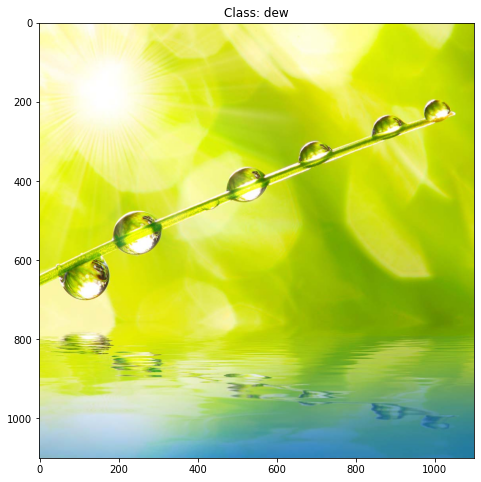

In [8]:
show_random_image(df)

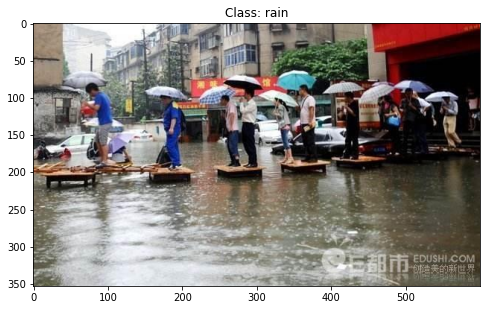

In [9]:
show_random_image(df)

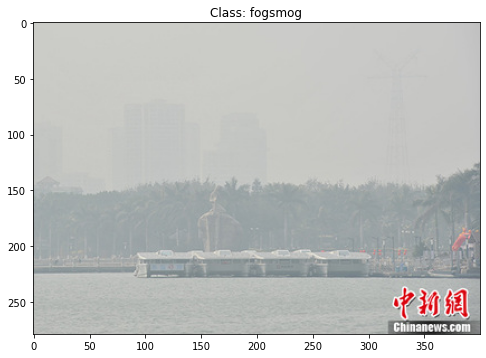

In [10]:
show_random_image(df)

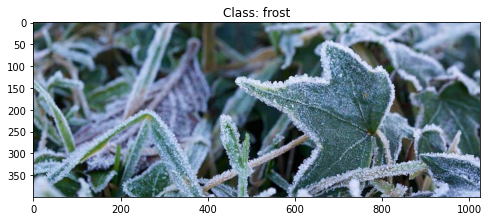

In [11]:
show_random_image(df)

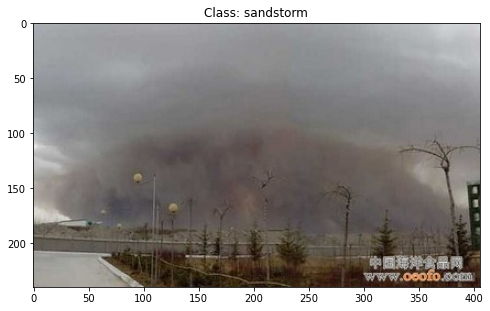

In [12]:
show_random_image(df)

## Split Data
Let's now split the data into training, test and validation sets.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split in train and test
for train_index, test_index in sss.split(df.drop(columns="label"), df["label"]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]

TRAIN: [1132 1816 4830 ... 3947 2155 5947] TEST: [6108  720 2834 ... 3024 1461 1047]


In [14]:
# split in train and validation
df_train_tmp = df_train.copy()
for train_index, test_index in sss.split(df_train_tmp.drop(columns="label"), df_train_tmp["label"]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df_train_tmp.iloc[train_index]
    df_val = df_train_tmp.iloc[test_index]

TRAIN: [3513 1304 1064 ... 3328 1793 3493] TEST: [ 257  974 3999 ... 3871 4574 4067]


In [15]:
# quickly check if number of samples of train + test still matches the total number of samples
assert df_train.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0], "Number of samples in splits does not match"

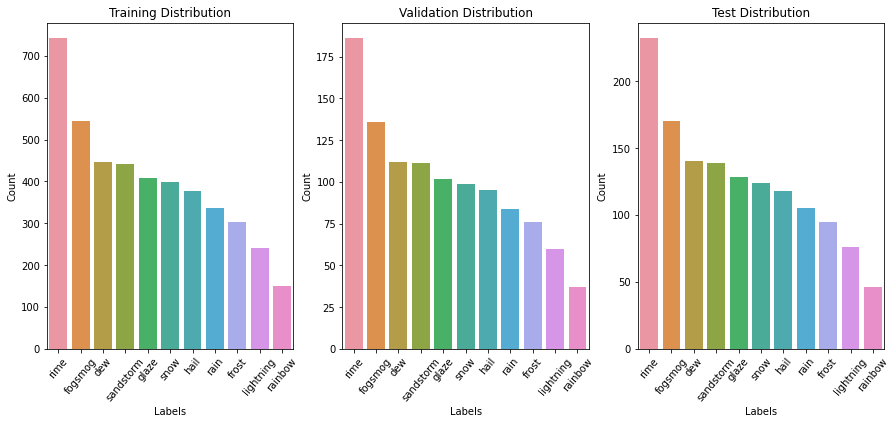

In [16]:
fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
counts = df_train["label"].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title("Training Distribution")
plt.xticks(rotation=50);

plt.subplot(1, 3, 2)
counts = df_val["label"].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title("Validation Distribution")
plt.xticks(rotation=50);

plt.subplot(1, 3, 3)
counts = df_test["label"].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title("Test Distribution")
plt.xticks(rotation=50);

## Create Input Pipeline and Check
Let's now create the input pipeline and verify that the images still look okay. Here, I first want to only use some very basic augmentations and I want to resize the images to a fixed size.

In [17]:
datagen_training = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                                   rescale=1./255.)
datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

datagen_train = datagen_training.flow_from_dataframe(df_train, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=(128, 128),
                                                     color_mode="rgb",
                                                     class_mode="categorical",
                                                     batch_size=16,
                                                     seed=42)

datagen_val = datagen_test.flow_from_dataframe(df_val, 
                                             directory="dataset", 
                                             x_col="filepath",
                                             y_col="label",
                                             target_size=(128, 128),
                                             color_mode="rgb",
                                             class_mode="categorical",
                                             batch_size=16,
                                             seed=42)

Found 4391 validated image filenames belonging to 11 classes.
Found 1098 validated image filenames belonging to 11 classes.


In [18]:
def show_random_image_generator(batch, label, batch_size=16):
    rand_ind = np.random.randint(0, batch_size)
    plt.imshow(batch[rand_ind], cmap='gray', vmin=0, vmax=1)
    #plt.title(f"Class label: {label}")
    plt.show()

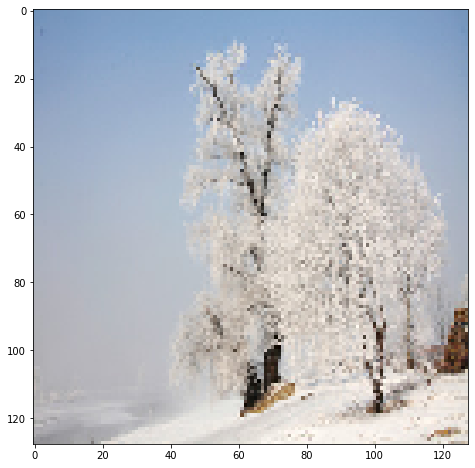

In [19]:
batch, label = next(datagen_train)
show_random_image_generator(batch, label)

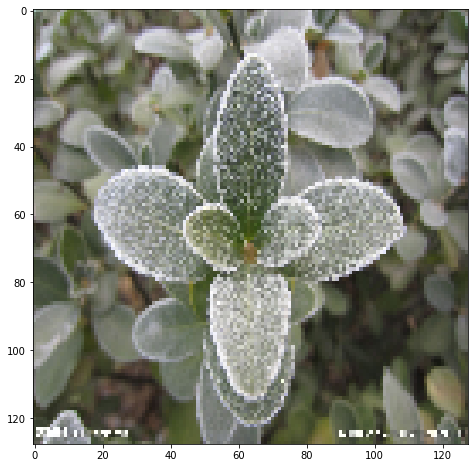

In [20]:
batch, label = next(datagen_train)
show_random_image_generator(batch, label)

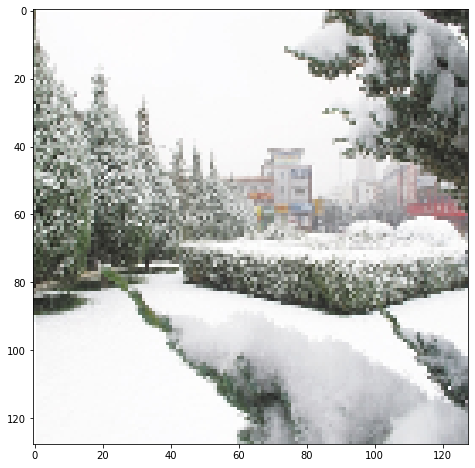

In [21]:
batch, label = next(datagen_train)
show_random_image_generator(batch, label)

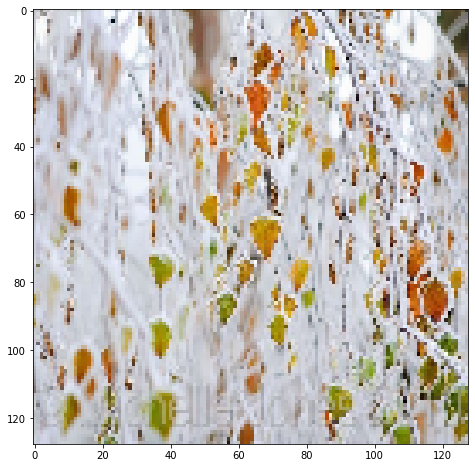

In [22]:
batch, label = next(datagen_train)
show_random_image_generator(batch, label)

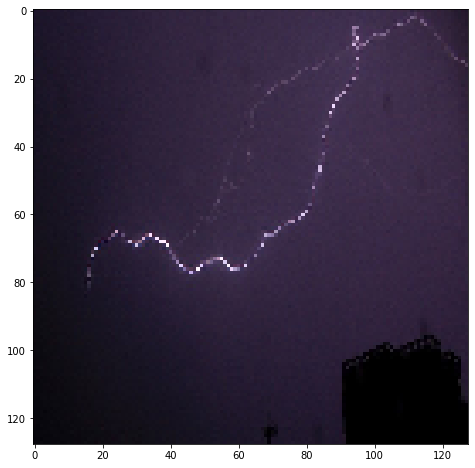

In [23]:
batch, label = next(datagen_train)
show_random_image_generator(batch, label)

Well. The input pipeline looks good. It can later be used for the training process. Let's now create an own CNN and a class with all CNNS which can be later called to compare different CNN architectures.

In [24]:
def create_custom_model(input_shape, num_classes=NUM_CLASSES):
    X_input = tf.keras.Input(input_shape, name="Input")
    
    X = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding="same")(X_input)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding="same")(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X_reduced = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X)
    
    X = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding="same")(X_reduced)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding="same")(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X)
    
    X = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding="same")(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # add output part
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(128, activation="relu")(X)
    X = tf.keras.layers.Dense(128, activation="relu")(X)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(X)
    
    # finally: create model
    model = tf.keras.Model(inputs=X_input, outputs=predictions)
    
    return model

In [25]:
custom_model = create_custom_model(input_shape=(256, 256, 1))

In [26]:
custom_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256   

Let's now create a function that takes in a model and some parameters and runs full training using that model. This is the end-to-end training pipeline.

### Model Factory Class

In [27]:
class Model_Factory():
    '''
    This class can be used to create a keras model and return it.
    '''
    def __init__(self):
        '''
        Constructor.
        '''
        pass
    
    def create_and_return_keras_model(self, model_name, num_classes, input_shape, 
                                      activation_func="softmax", transfer_learning=False):
        '''
        This function takes some information about the keras model to create and returns it. The model_name must be one
        of the following: ["efficientnetb0", "efficientnetb2", "xception", "densenet121", "resnet18", "resnet34", "custom"]
        
        Args:
            model_name (str): Name of the keras model which shall be instantiated.
            num_classes (int): The number of classes and therefore the number of output neurons.
            input_shape (tuple): Shape of input images (height, widht, depth)
            activation_func (str): Activation function that should be used on the output layer
            transfer_learning (bool): Whether to reuse the trained weights on the imagenet dataset 
                                         or to use newly initialized weights
        '''
        if (not isinstance(model_name, str)):
                raise ValueError("Input model_name has the wrong datatype!")
        
        if not isinstance(num_classes, int):
            raise ValueError("Input num_classes has the wrong datatype!")
        
        if not isinstance(transfer_learning, bool):
            raise ValueError("Input transfer_leraning has the wrong datatype!")
        
        if not isinstance(activation_func, str):
            raise ValueError("Input activation_func has the wrong datatype!")
        
        weights = "imagenet" if transfer_learning else None
        
        if model_name == "custom":
            model = create_custom_model(input_shape=input_shape, num_classes=num_classes)
        else:
            if model_name == "efficientnetb0":
                from tensorflow.keras.applications import EfficientNetB0
                model = EfficientNetB0(weights=weights, include_top=False, input_shape=input_shape)
            elif model_name == "efficientnetb2":
                from tensorflow.keras.applications import EfficientNetB2
                model = EfficientNetB2(weights=weights, include_top=False, input_shape=input_shape)
            elif model_name == "xception":
                from tensorflow.keras.applications import Xception
                model = Xception(weights=weights, include_top=False, input_shape=input_shape)
            else:
                from classification_models.tfkeras import Classifiers
                net, _ = Classifiers.get(model_name)
                model = net(input_shape=input_shape, weights=weights, include_top=False)

            # add output part
            x = model.output
            x = tf.keras.layers.Flatten()(x)
            x = tf.keras.layers.Dense(128, activation="relu")(x)
            x = tf.keras.layers.Dense(128, activation="relu")(x)

            # and a fully connected output/classification layer
            predictions = tf.keras.layers.Dense(num_classes, activation=activation_func)(x)

            # create the full network so we can train on it
            model = tf.keras.models.Model(inputs=model.input, outputs=predictions)
        
        return model

In [28]:
factory = Model_Factory()

In [36]:
def end_to_end_training(model, datagen_train, datagen_val, num_epochs, lr_val=4e-3, num_classes=NUM_CLASSES, callbacks=None):
    # create keras optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=lr_val)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tfa.metrics.F1Score(num_classes=num_classes, average='weighted')
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)

    # fit the model for num_epochs epochs
    with tf.device("/GPU:0"):
        hist_dict = model.fit(datagen_train, epochs=num_epochs, verbose=1, validation_data=datagen_val, callbacks=callbacks)
    return hist_dict

Let's now compare all the models using the f1-score due to the imbalanced dataset. Let's train each model for a fixed number of epochs and compare the best validation f1-score. <br> <br>
I am going to use transfer learning to use maybe already useful features from imagenet learning. But transfer learning is not applied on the custom model, because this one has never been trained yet! <br> <br>
In addition, I am using the ReduceLROnPlateau callback from tensorflow in order to avoid the models from hanging in a saddle point or local minumum (happend the first time I've run this evaluation!). 

In [30]:
def create_loss_plots(results_hists_dict, figpath=r"figures\encoder_search_loss.pdf",
                      num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates a loss plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["loss"], label="Train")
        plt.plot(hist_dict["val_loss"], label="Val")
        
        if(idx >= num_cols):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == num_cols):
            plt.ylabel("Loss")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

In [31]:
def create_f1_plots(results_hists_dict, figpath=r"figures\encoder_search_f1_score.pdf",
                    num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates a f1-score plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["f1_score"], label="Train")
        plt.plot(hist_dict["val_f1_score"], label="Val")
        
        if(idx >= num_cols):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == num_cols):
            plt.ylabel("F1-Score")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

In [42]:
encoder_list = ["custom", "efficientnetb2", "xception", "densenet121", "resnet18", "resnet50"]
target_size = (256, 256)
num_epochs = 30
batch_size = 16
results_dict = dict()
results_hists_dict = dict()
img_height, img_width = target_size
color_mode = "rgb"
img_depth = 3

datagen_training = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, rescale=1./255.)
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

datagen_train = datagen_training.flow_from_dataframe(df_train, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=target_size,
                                                     color_mode=color_mode,
                                                     class_mode="categorical",
                                                     batch_size=batch_size,
                                                     seed=42)

datagen_val = datagen_valid.flow_from_dataframe(df_val, 
                                                 directory="dataset", 
                                                 x_col="filepath",
                                                 y_col="label",
                                                 target_size=target_size,
                                                 color_mode=color_mode,
                                                 class_mode="categorical",
                                                 batch_size=batch_size,
                                                 seed=42)

# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)

for encoder in encoder_list:
    print(f"Start training {encoder}...")
    
            
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=NUM_CLASSES, 
                                                  input_shape=(img_height, img_width, img_depth),
                                                  activation_func="softmax",
                                                  transfer_learning=True)

    hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                    num_epochs=num_epochs, callbacks=[reduce_lr])

    # get the maximum validation f1-score and validation accuracy and store them
    results_dict[encoder] = np.max(hist_dict.history["val_f1_score"])

    # save also the history in order to make some nice visualizations
    results_hists_dict[encoder] = hist_dict.history

Found 4391 validated image filenames belonging to 11 classes.
Found 1098 validated image filenames belonging to 11 classes.
Start training custom...
Epoch 1/30
275/275 [==============================] - 31s 108ms/step - loss: 1.8118 - accuracy: 0.4020 - f1_score: 0.3860 - val_loss: 1.7718 - val_accuracy: 0.4636 - val_f1_score: 0.4242
Epoch 2/30
275/275 [==============================] - 27s 99ms/step - loss: 1.4442 - accuracy: 0.5083 - f1_score: 0.4953 - val_loss: 2.3512 - val_accuracy: 0.3944 - val_f1_score: 0.3830
Epoch 3/30
275/275 [==============================] - 28s 102ms/step - loss: 1.3503 - accuracy: 0.5404 - f1_score: 0.5291 - val_loss: 1.2477 - val_accuracy: 0.6002 - val_f1_score: 0.5825
Epoch 4/30
275/275 [==============================] - 28s 103ms/step - loss: 1.2578 - accuracy: 0.5821 - f1_score: 0.5745 - val_loss: 1.5050 - val_accuracy: 0.5200 - val_f1_score: 0.5025
Epoch 5/30
275/275 [==============================] - 29s 104ms/step - loss: 1.1987 - accuracy: 0.5944 -

275/275 [==============================] - 71s 260ms/step - loss: 2.3297 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3281 - val_accuracy: 0.1694 - val_f1_score: 0.0491

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 13/30
275/275 [==============================] - 71s 260ms/step - loss: 2.3293 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 14/30
275/275 [==============================] - 71s 259ms/step - loss: 2.3292 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 15/30
275/275 [==============================] - 72s 262ms/step - loss: 2.3293 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 16/30
275/275 [==============================] - 71s 260ms/step - loss: 2.3292 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 1

Epoch 25/30
275/275 [==============================] - 77s 281ms/step - loss: 0.8077 - accuracy: 0.7165 - f1_score: 0.7096 - val_loss: 0.8598 - val_accuracy: 0.7104 - val_f1_score: 0.7103
Epoch 26/30
275/275 [==============================] - 78s 282ms/step - loss: 0.7946 - accuracy: 0.7276 - f1_score: 0.7224 - val_loss: 1.0439 - val_accuracy: 0.6503 - val_f1_score: 0.6417
Epoch 27/30
275/275 [==============================] - 77s 280ms/step - loss: 0.7467 - accuracy: 0.7365 - f1_score: 0.7311 - val_loss: 0.7919 - val_accuracy: 0.7322 - val_f1_score: 0.7250
Epoch 28/30
275/275 [==============================] - 77s 282ms/step - loss: 0.7329 - accuracy: 0.7483 - f1_score: 0.7430 - val_loss: 0.8323 - val_accuracy: 0.7268 - val_f1_score: 0.7150
Epoch 29/30
275/275 [==============================] - 77s 280ms/step - loss: 0.7219 - accuracy: 0.7413 - f1_score: 0.7359 - val_loss: 0.8559 - val_accuracy: 0.7095 - val_f1_score: 0.6926
Epoch 30/30
275/275 [==============================] - 78s 2

275/275 [==============================] - 24s 89ms/step - loss: 2.3325 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3290 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 8/30
275/275 [==============================] - 24s 89ms/step - loss: 2.3314 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3295 - val_accuracy: 0.1694 - val_f1_score: 0.0491

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 9/30
275/275 [==============================] - 25s 89ms/step - loss: 2.3302 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3282 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 10/30
275/275 [==============================] - 25s 90ms/step - loss: 2.3297 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3281 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 11/30
275/275 [==============================] - 25s 90ms/step - loss: 2.3297 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3281 - val_accuracy: 0.1694 - val_f1_score: 0.049

275/275 [==============================] - 47s 171ms/step - loss: 2.3293 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 20/30
275/275 [==============================] - 47s 171ms/step - loss: 2.3294 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3281 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 21/30
275/275 [==============================] - 47s 171ms/step - loss: 2.3294 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 22/30
275/275 [==============================] - 47s 171ms/step - loss: 2.3293 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 23/30
275/275 [==============================] - 48s 175ms/step - loss: 2.3294 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 24/30
275/275 [==============================] - 49s 177ms/step - 

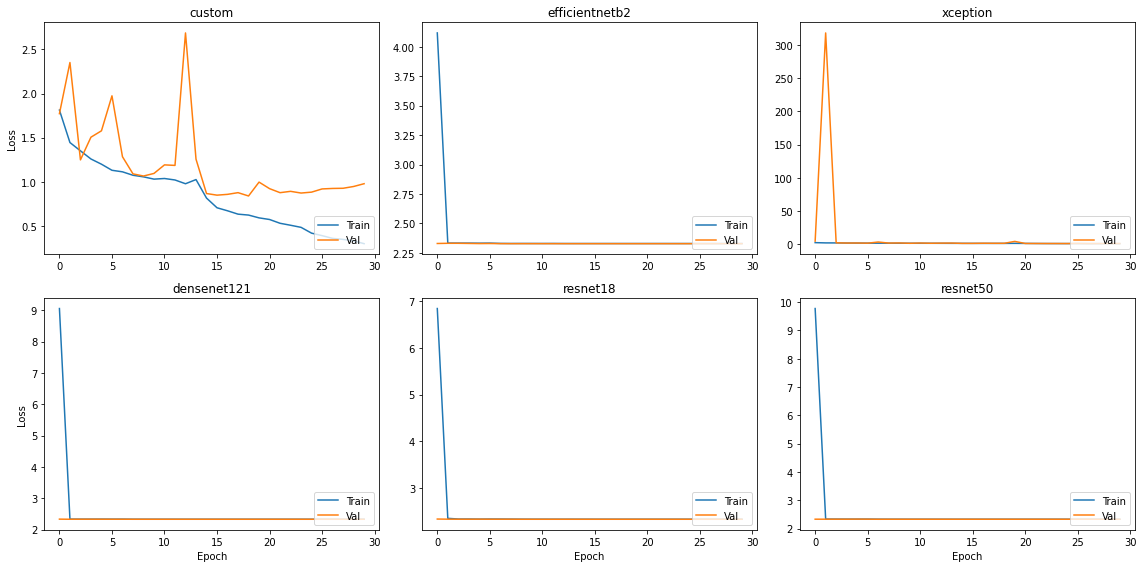

In [43]:
create_loss_plots(results_hists_dict)

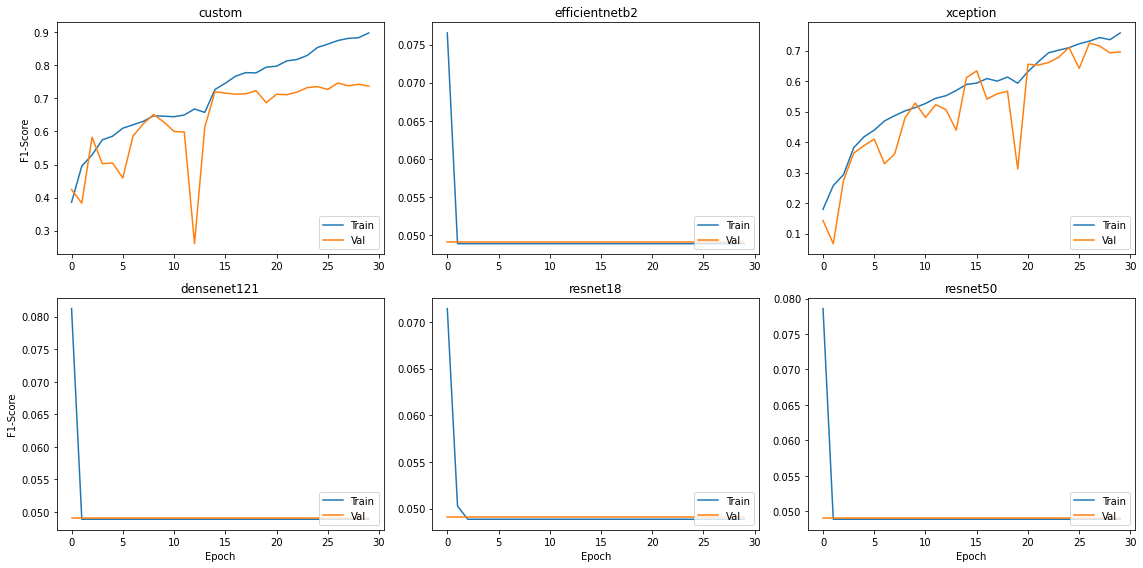

In [44]:
create_f1_plots(results_hists_dict)

In [45]:
df_results = (pd.DataFrame.
              from_dict(results_dict, orient="index", columns=["F1-Score"])
              .sort_values(by=["F1-Score"], ascending=False)
             )
df_results

,F1-Score
custom,0.746826
xception,0.725033
efficientnetb2,0.049078
densenet121,0.049078
resnet18,0.049078
resnet50,0.049078


Okay. Seems like only the custom version and the Xception CNN worked out well. The others didn't even learn something. So here it could be interesting to increase the learning rate for example or to try to remove regularization by removing dropout, ...
But for now, I continue with the first two architectures. And for this I know want to train both again but this time with selected augmentations. This shall then finally deliver the final architecture to continue with.

## Add Augmentations
Now it's time to add some augmentations to further boost model performance. I checked different augmentations in the notebook "Check_Augmentations". I applied them on the image and checked whether the output makes sense or not. I don't want to always apply all augmentations. For this purpose, I only apply each augmentation with a certain probability, such that approximately 10% of the images are not augmented.

In [51]:
def apply_augmentation(input_image):
    input_image = np.expand_dims(input_image, axis=0)
    aug_list = [
                iaa.Fliplr(1.0),
                [iaa.Multiply((0.5, 1.5)), iaa.Add((-60, 60))],
                iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
                iaa.GaussianBlur(sigma=(0.5, 1.0)),
                iaa.Affine(scale=(0.5, 1.2)),
                iaa.Rotate((-45, 45)),
                iaa.ElasticTransformation(alpha=(50.0, 300.0), sigma=25.0),
              ]                
    for idx, aug in enumerate(aug_list):
        # only apply augmentation such that in total 10% of the images are not augmented
        # P_single_aug = 1 - exp((1/N) * ln(P_not_aug)) ~ 0.28
        rand_nr = np.random.rand()
        threshold = 0.28
        if isinstance(aug, list):
            rand_aug = np.random.randint(0, 2)
            input_image = np.clip(aug[rand_aug](images=input_image), 0., 255.) if rand_nr <= threshold else input_image
        else:
            input_image = np.clip(aug(images=input_image), 0., 255.) if rand_nr <= threshold else input_image

    return np.squeeze(input_image, axis=0)

In [63]:
encoder_list = ["custom", "xception"]
target_size = (256, 256)
num_epochs = 50
batch_size = 16
results_dict_augs = dict()
results_hists_dict_augs = dict()
img_height, img_width = target_size
color_mode = "rgb"
img_depth = 3

datagen_training = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., preprocessing_function=apply_augmentation)
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

datagen_train = datagen_training.flow_from_dataframe(df_train, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=target_size,
                                                     color_mode=color_mode,
                                                     class_mode="categorical",
                                                     batch_size=batch_size,
                                                     seed=42)

datagen_val = datagen_valid.flow_from_dataframe(df_val, 
                                                 directory="dataset", 
                                                 x_col="filepath",
                                                 y_col="label",
                                                 target_size=target_size,
                                                 color_mode=color_mode,
                                                 class_mode="categorical",
                                                 batch_size=batch_size,
                                                 seed=42)

# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)

for encoder in encoder_list:
    print(f"Start training {encoder}...")
    
            
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=NUM_CLASSES, 
                                                  input_shape=(img_height, img_width, img_depth),
                                                  activation_func="softmax",
                                                  transfer_learning=True)

    hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                    num_epochs=num_epochs, callbacks=[reduce_lr])

    # get the maximum validation f1-score and validation accuracy and store them
    results_dict_augs[encoder] = np.max(hist_dict.history["val_f1_score"])

    # save also the history in order to make some nice visualizations
    results_hists_dict_augs[encoder] = hist_dict.history

Found 4391 validated image filenames belonging to 11 classes.
Found 1098 validated image filenames belonging to 11 classes.
Start training custom...
Epoch 1/50
275/275 [==============================] - 84s 303ms/step - loss: 1.9874 - accuracy: 0.3482 - f1_score: 0.3283 - val_loss: 1.9400 - val_accuracy: 0.3616 - val_f1_score: 0.3222
Epoch 2/50
275/275 [==============================] - 80s 291ms/step - loss: 1.6492 - accuracy: 0.4391 - f1_score: 0.4113 - val_loss: 7.0262 - val_accuracy: 0.1093 - val_f1_score: 0.0852
Epoch 3/50
275/275 [==============================] - 81s 294ms/step - loss: 1.5472 - accuracy: 0.4844 - f1_score: 0.4653 - val_loss: 1.3996 - val_accuracy: 0.5328 - val_f1_score: 0.5094
Epoch 4/50
275/275 [==============================] - 82s 297ms/step - loss: 1.4979 - accuracy: 0.4905 - f1_score: 0.4766 - val_loss: 2.0336 - val_accuracy: 0.3707 - val_f1_score: 0.3328
Epoch 5/50
275/275 [==============================] - 80s 292ms/step - loss: 1.4271 - accuracy: 0.5097 

275/275 [==============================] - 84s 304ms/step - loss: 0.6847 - accuracy: 0.7622 - f1_score: 0.7616 - val_loss: 0.8486 - val_accuracy: 0.7432 - val_f1_score: 0.7399
Epoch 44/50
275/275 [==============================] - 86s 311ms/step - loss: 0.6688 - accuracy: 0.7629 - f1_score: 0.7624 - val_loss: 0.8367 - val_accuracy: 0.7295 - val_f1_score: 0.7256
Epoch 45/50
275/275 [==============================] - 85s 308ms/step - loss: 0.6655 - accuracy: 0.7693 - f1_score: 0.7681 - val_loss: 0.8587 - val_accuracy: 0.7341 - val_f1_score: 0.7309
Epoch 46/50
275/275 [==============================] - 86s 314ms/step - loss: 0.6400 - accuracy: 0.7809 - f1_score: 0.7802 - val_loss: 0.8344 - val_accuracy: 0.7332 - val_f1_score: 0.7328
Epoch 47/50
275/275 [==============================] - 86s 314ms/step - loss: 0.6423 - accuracy: 0.7741 - f1_score: 0.7736 - val_loss: 0.8367 - val_accuracy: 0.7386 - val_f1_score: 0.7355
Epoch 48/50
275/275 [==============================] - 87s 315ms/step - 

Epoch 36/50
275/275 [==============================] - 91s 329ms/step - loss: 1.1416 - accuracy: 0.5980 - f1_score: 0.5836 - val_loss: 1.0485 - val_accuracy: 0.6457 - val_f1_score: 0.6309
Epoch 37/50
275/275 [==============================] - 89s 322ms/step - loss: 1.1499 - accuracy: 0.6085 - f1_score: 0.5955 - val_loss: 1.0275 - val_accuracy: 0.6603 - val_f1_score: 0.6458
Epoch 38/50
275/275 [==============================] - 90s 328ms/step - loss: 1.1063 - accuracy: 0.6147 - f1_score: 0.5991 - val_loss: 1.0104 - val_accuracy: 0.6667 - val_f1_score: 0.6545
Epoch 39/50
275/275 [==============================] - 90s 328ms/step - loss: 1.1028 - accuracy: 0.6242 - f1_score: 0.6126 - val_loss: 1.0342 - val_accuracy: 0.6630 - val_f1_score: 0.6473
Epoch 40/50
275/275 [==============================] - 90s 325ms/step - loss: 1.0878 - accuracy: 0.6233 - f1_score: 0.6125 - val_loss: 0.9914 - val_accuracy: 0.6740 - val_f1_score: 0.6562
Epoch 41/50
275/275 [==============================] - 92s 3

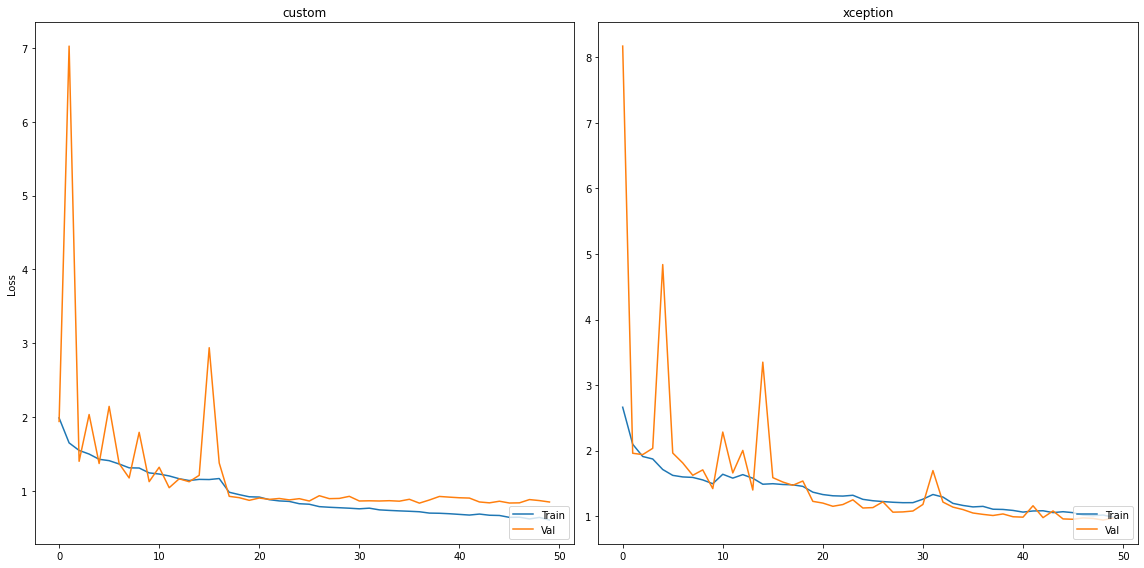

In [64]:
create_loss_plots(results_hists_dict_augs, figpath=r"figures\augmentation_loss.pdf",
                  num_rows=1, num_cols=2)

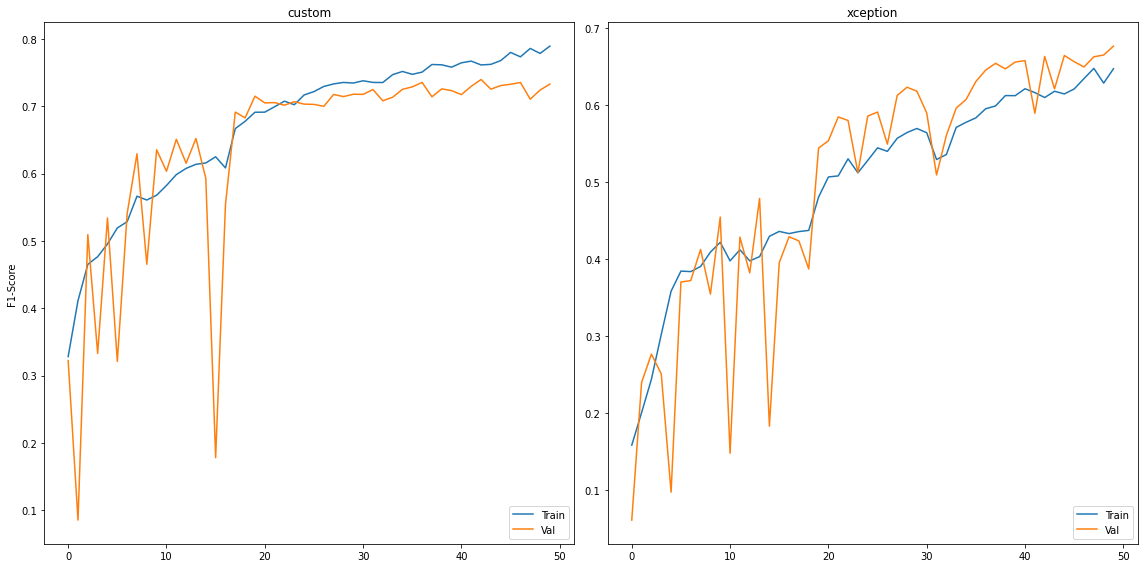

In [65]:
create_f1_plots(results_hists_dict_augs, figpath=r"figures\augmentation_f1_score.pdf",
                num_rows=1, num_cols=2)

In [66]:
df_results = (pd.DataFrame.
              from_dict(results_dict_augs, orient="index", columns=["F1-Score"])
              .sort_values(by=["F1-Score"], ascending=False)
             )
df_results

,F1-Score
custom,0.739899
xception,0.676895


Okay well. Seems like the custom version really works best. The augmentations didn't really boost the validation performance, but they led to less overfitting of the custom CNN and therefore lead to a more stable and more generalized CNN architecture. <br> <br>
Let's now try out different imbalance strategies and compare them to the imbalanced model to decide which strategy works best.

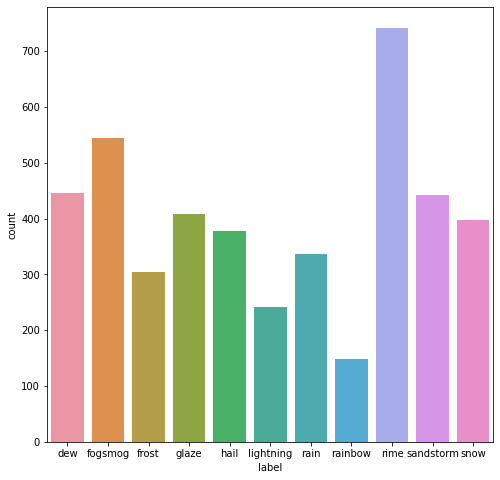

In [71]:
# quick view into training set distribution again
sns.countplot(data=df_train, x="label", order=sorted(sorted(set(df_train["label"]))));

Options to try out:
1. Oversampling: Oversample each class to match the number of samples of the majority class (here: rime). 
2. Undersampling: Undersample each class to match the number of samples of the minority class (here: rainbow).
3. Undersampling with re-sampling: Same as undersampling, but re-sample during training to reduce influence of lost information.

In [89]:
def oversample_dataframe(df_train):
    '''
    This function oversamples the input dataframe to have as many samples per class as the majority class.
    
    Args:
        df_train (pandas DataFrame): The training dataframe that shall be oversampled
    
    Returns:
        final_dataframe (pandas DataFrame): The oversampled dataframe
    '''
    # create copy of dataframe
    df_copy = df_train.copy()
    
    # get list of class_names
    class_names = set(df_copy["label"])
    
    # find majortiy class count
    count_majority = max(df_copy["label"].value_counts().values)
    
    # loop over all classes and oversample until count_majority is reached
    balanced_columns_list = list()
    for label in class_names:
        # create a smaller dataframe only containing the rows with images of the current class
        df_class_current = df_copy[df_copy["label"] == label]
        
        # get the number of samples within that class
        count_class_current = df_class_current.shape[0]
        
        # copy samples from current class until as many samples as in majority class are reached and store them in a dataframe
        df_oversampled = df_class_current.sample(count_majority - count_class_current, replace=True)
        
        # add new oversampled data to initial data and add to list of new dataframe columns
        balanced_columns_list.append(pd.concat([df_class_current, df_oversampled]))
    
    # concatenate all dataframes togehter to get the final one
    final_dataframe = pd.concat(balanced_columns_list)
    
    return final_dataframe

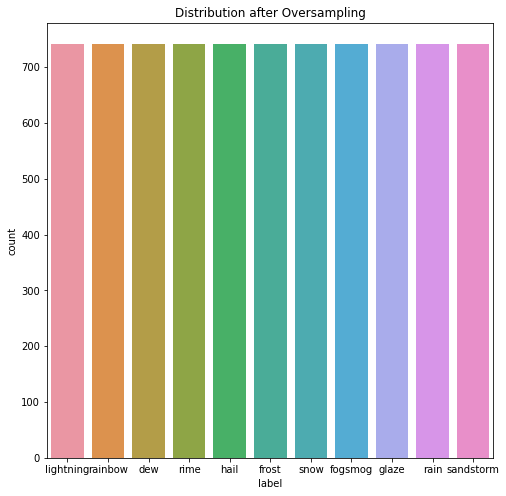

In [90]:
# check if oversampling worked
df_train_oversampled = oversample_dataframe(df_train)
sns.countplot(data=df_train_oversampled, x="label")
plt.title("Distribution after Oversampling")
plt.show()

In [94]:
def undersample_dataframe(df_train, random_seed=42):
    '''
    This function undersamples the input dataframe to have as many samples per class as the minority class. 
    It takes a random_seed as input to allow undersampling with different samples drawn after repeated execution 
    (this is required for undersampling with re-sampling).
    
    Args:
        df_train (pandas DataFrame): The training dataframe that shall be undersampled
        random_seed (integer): Seed used for randomly sampling from the given data
    
    Returns:
        final_dataframe (pandas DataFrame): The undersampled dataframe
    '''
    # create copy of dataframe
    df_copy = df_train.copy()
    
    # get list of class_names
    class_names = set(df_copy["label"])
    
    # find majortiy class count
    count_minority = min(df_copy["label"].value_counts().values)
    
    # loop over all classes and oversample until count_majority is reached
    balanced_columns_list = list()
    for label in class_names:
        # create a smaller dataframe only containing the rows with images of the current class
        df_class_current = df_copy[df_copy["label"] == label]
        
        # get the number of samples within that class
        count_class_current = df_class_current.shape[0]
        
        # copy samples from current class until as many samples as in majority class are reached and store them in a dataframe
        df_undersampled = df_class_current.sample(count_minority, replace=False, random_state=random_seed)
        
        # add new oversampled data to initial data and add to list of new dataframe columns
        balanced_columns_list.append(df_undersampled)
    
    # concatenate all dataframes togehter to get the final one
    final_dataframe = pd.concat(balanced_columns_list)
    
    return final_dataframe

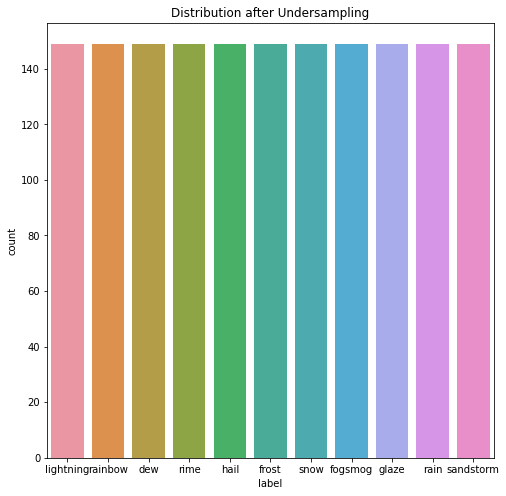

In [95]:
# check if undersampling worked
df_train_undersampled = undersample_dataframe(df_train)
sns.countplot(data=df_train_undersampled, x="label")
plt.title("Distribution after Undersampling")
plt.show()

Let's quickly check that the samples are different for different seeds and equal for equal seeds.

In [109]:
def compare_lists(list1, list2):
    return list1 == list2

In [114]:
test1 = undersample_dataframe(df_train, random_seed=10)["filepath"].to_list()
test2 = undersample_dataframe(df_train, random_seed=100)["filepath"].to_list()

assert compare_lists(test1, test2) == False, "The lists are identical, but should be different"

In [118]:
test3 = undersample_dataframe(df_train, random_seed=10)["filepath"].to_list()
test4 = undersample_dataframe(df_train, random_seed=10)["filepath"].to_list()

assert compare_lists(test3, test4) == True, "The lists are different, but should be identical"

Perfect. So the undersampling with re-sampling returns different datasets. This is awesome! Let's now train a model for each of these methods.

In [162]:
encoder = "custom"
target_size = (256, 256)
num_epochs = 60
batch_size = 16
results_dict_imbalance = dict()
results_hists_dict_imbalance = dict()
img_height, img_width = target_size
color_mode = "rgb"
img_depth = 3

datagen_training = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., preprocessing_function=apply_augmentation)
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

datagen_val = datagen_valid.flow_from_dataframe(df_val, 
                                                 directory="dataset", 
                                                 x_col="filepath",
                                                 y_col="label",
                                                 target_size=target_size,
                                                 color_mode=color_mode,
                                                 class_mode="categorical",
                                                 batch_size=batch_size,
                                                 seed=42)

Found 1098 validated image filenames belonging to 11 classes.


### Oversampling

In [ ]:
strategy = "oversampling"
df_train_oversampled = oversample_dataframe(df_train)
datagen_train = datagen_training.flow_from_dataframe(df_train_oversampled, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=target_size,
                                                     color_mode=color_mode,
                                                     class_mode="categorical",
                                                     batch_size=batch_size,
                                                     seed=42)



# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)

model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=NUM_CLASSES, 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)

hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                num_epochs=num_epochs, callbacks=[reduce_lr])

# get the maximum validation f1-score and validation accuracy and store them
results_dict_imbalance[strategy] = np.max(hist_dict.history["val_f1_score"])

# save also the history in order to make some nice visualizations
results_hists_dict_imbalance[strategy] = hist_dict.history

Found 8162 validated image filenames belonging to 11 classes.
Epoch 1/60
280/511 [===============>..............] - ETA: 1:13 - loss: 1.9816 - accuracy: 0.3341 - f1_score: 0.3334

## Undersampling

In [ ]:
strategy = "undersampling"
df_train_undersampled = undersample_dataframe(df_train)
datagen_train = datagen_training.flow_from_dataframe(df_train_undersampled, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=target_size,
                                                     color_mode=color_mode,
                                                     class_mode="categorical",
                                                     batch_size=batch_size,
                                                     seed=42)



# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)

model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=NUM_CLASSES, 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)

hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                num_epochs=num_epochs, callbacks=[reduce_lr])

# get the maximum validation f1-score and validation accuracy and store them
results_dict_imbalance[strategy] = np.max(hist_dict.history["val_f1_score"])

# save also the history in order to make some nice visualizations
results_hists_dict_imbalance[strategy] = hist_dict.history

### Undersampling with Re-Sampling
Here, I like to re-sample after every fifth epoch to introduce new samples.

In [ ]:
def convert_history_dicts_to_hist(history_dicts):
    '''
    This function takes a list of history dicts returned from keras.fit() function and converts them to one global history.
    This is usefull in case re-sampling is applied and one global history should be stored.

    Args:
        history_dicts (list of dictionaries): List of dictioniaries containing the results of keras.fit() return

    Returns:
        new_history (dict): New history with concatenated results        
    '''
    new_history = history_dicts[0].history.copy()
    for idx in range(1, len(history_dicts)):
        for key in history_dicts[idx].history.keys():
            new_history[key] += history_dicts[idx].history[key]      

    return new_history   

In [ ]:
strategy = "undersampling_with_resampling"

# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)
        
model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=NUM_CLASSES, 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)
history_dicts_list = list()
for epoch in range(1, num_epochs+1, 5):
    print(f"Epoch {epoch}/{num_epochs}")
    random_seed = np.random.randint(0, 1000)
    df_train_undersampled = undersample_dataframe(df_train)
    datagen_train = datagen_training.flow_from_dataframe(df_train_undersampled, 
                                                         directory="dataset", 
                                                         x_col="filepath",
                                                         y_col="label",
                                                         target_size=target_size,
                                                         color_mode=color_mode,
                                                         class_mode="categorical",
                                                         batch_size=batch_size,
                                                         seed=42)


    hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                    num_epochs=5, callbacks=[reduce_lr])
    history_dicts_list.append(hist_dict)

# save also the history in order to make some nice visualizations
results_hists_dict_imbalance[strategy] = convert_history_dicts_to_hist(history_dicts_list)

# get the maximum validation f1-score and validation accuracy and store them
results_dict_imbalance[strategy] = np.max(results_hists_dict_imbalance[strategy]["val_f1_score"])

In [ ]:
create_loss_plots(results_hists_dict_imbalance, figpath=r"figures\imbalance_loss.pdf",
                  num_rows=1, num_cols=3)

In [ ]:
create_f1_plots(results_hists_dict_imbalance, figpath=r"figures\imbalance_f1_score.pdf",
                num_rows=1, num_cols=3)

In [ ]:
df_results = (pd.DataFrame.
              from_dict(results_dict_imbalance, orient="index", columns=["F1-Score"])
              .sort_values(by=["F1-Score"], ascending=False)
             )
df_results